In [1]:
import geopandas
import numpy as np
import pandas as pd
import contextily as cx
from matplotlib import pyplot as plt
import sklearn
import networkx as nx
import osmnx as ox
import algo
import pickle
import os

In [2]:
df_store = pd.read_excel('test_data.xlsx', sheet_name='Stores')
df_store.head()

,Store,lat,long,Metric Store
0,Store 1,50.415258,30.522344,2.182985
1,Store 2,50.495292,30.512299,2.636889
2,Store 3,50.414301,30.650869,2.503791
3,Store 4,50.471703,30.478740,2.376577
4,Store 5,50.532248,30.608288,2.340841


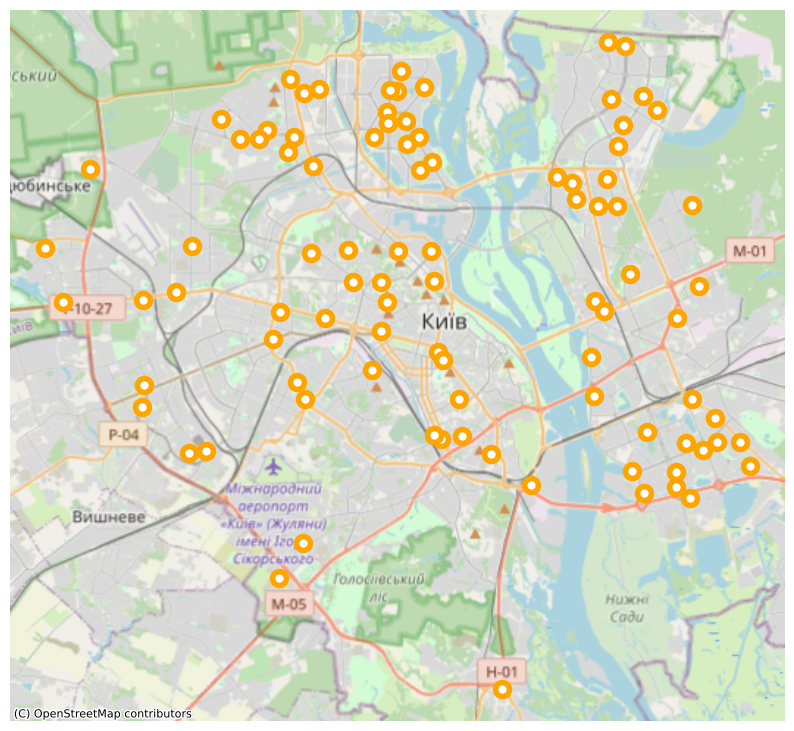

In [3]:
df_store_geo = geopandas.GeoDataFrame(df_store, geometry=geopandas.points_from_xy(df_store["long"], df_store["lat"]), crs='EPSG:4326').to_crs(epsg=9821)

fig, ax = plt.subplots(figsize=(10, 10))
ax = df_store_geo.plot(ax=ax, color="white", marker='o', markersize=100, edgecolor='orange', lw=4)
cx.add_basemap(ax, crs=df_store_geo.crs, source=cx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()

# Now I calculate distances between the stores
### I assume that distance from store1 to store2 is the same as store2 to store1
### I form a complete graph with nodes as stores and edges - route distance between them

In [4]:
place = "Kyiv, Ukraine"
G_map = ox.graph_from_place(place, network_type="drive")

def route_distance(x, y, G=G_map):
    return algo.get_route_distance(x, y, G)

In [5]:
stores = df_store[["long", "lat"]].to_numpy()
if "stores_graph" not in os.listdir('saved_data'):
    G = nx.Graph()
    G.add_nodes_from(df_store.index)
    for i in range(len(df_store)):
        for j in range(i+1, len(df_store)):
            G.add_edge(i, j, route_distance=route_distance(stores[i], stores[j]))
    pickle.dump(G, open("saved_data/stores_graph", 'wb'))
else:
    G = pickle.load(open("saved_data/stores_graph", 'rb'))
print(G.number_of_nodes(), G.number_of_edges())

92 4186


# The problem is a classic Traveling Salesemen Problem
# First, I want to try a greedy algorithm
### traverse the formed graph from random node, choosing the shortest edge to the next node
### it is a time and memory efficient method, that will give a good baseline

In [6]:
import random
random.seed(21)

def greedy_algo(G, starting_node=None):
    """
    Implementation of the greedy algorithm (nearest neighbor search)
    Input:
    G - networkx graph: nodes - stores, edges - route distance between them, G is fully connected
    starting_node - node of G: starting node of greedy algorithm
    
    Output:
    list of nodes in order of travel"""
    if starting_node is None:
        starting_node = random.choice(list(G.nodes))
    traversed_nodes = [starting_node]
    while len(traversed_nodes) != G.number_of_nodes():
        node_dict = {(i, j): G.edges[(i, j)]['route_distance'] for (i, j) in G.edges(starting_node) if j not in traversed_nodes}
        smallest_route = min(node_dict, key=node_dict.get)
        closest_store = smallest_route[1]
        traversed_nodes.append(closest_store)
        starting_node = closest_store
    return traversed_nodes

In [7]:
path1 = greedy_algo(G)
path2 = greedy_algo(G)
path3 = greedy_algo(G)

In [8]:
def get_route_distance_km(G, path):
    """
    Compute total route distance of path
    Input:
    G - networkx graph: nodes - stores, edges - route distance between them, G is fully connected
    path - list, nodes in order of travel
    Output: 
    float - route distance of the path
    """
    path_edges = [(path[i], path[i+1]) for i in range(len(path)-1)]+[(path[-1], path[0])]
    r_sum = sum([G.edges[i]["route_distance"] for i in path_edges])
    return round(r_sum/1000, 2)


def plot_path(traversed_nodes, stores=stores):
    """Plots the coumplete cycle"""
    plt.plot(stores[traversed_nodes, 0], stores[traversed_nodes, 1],  c='k', lw=2)
    plt.plot(stores[[traversed_nodes[-1], traversed_nodes[0]], 0], stores[[traversed_nodes[-1], traversed_nodes[0]], 1],  c='k', lw=2)
    plt.title(f"Complete route takes {get_route_distance_km(G, traversed_nodes)}, km")
    plt.plot(stores[:, 0], stores[:, 1],  "o", color="orange",  markersize=10, lw=3)

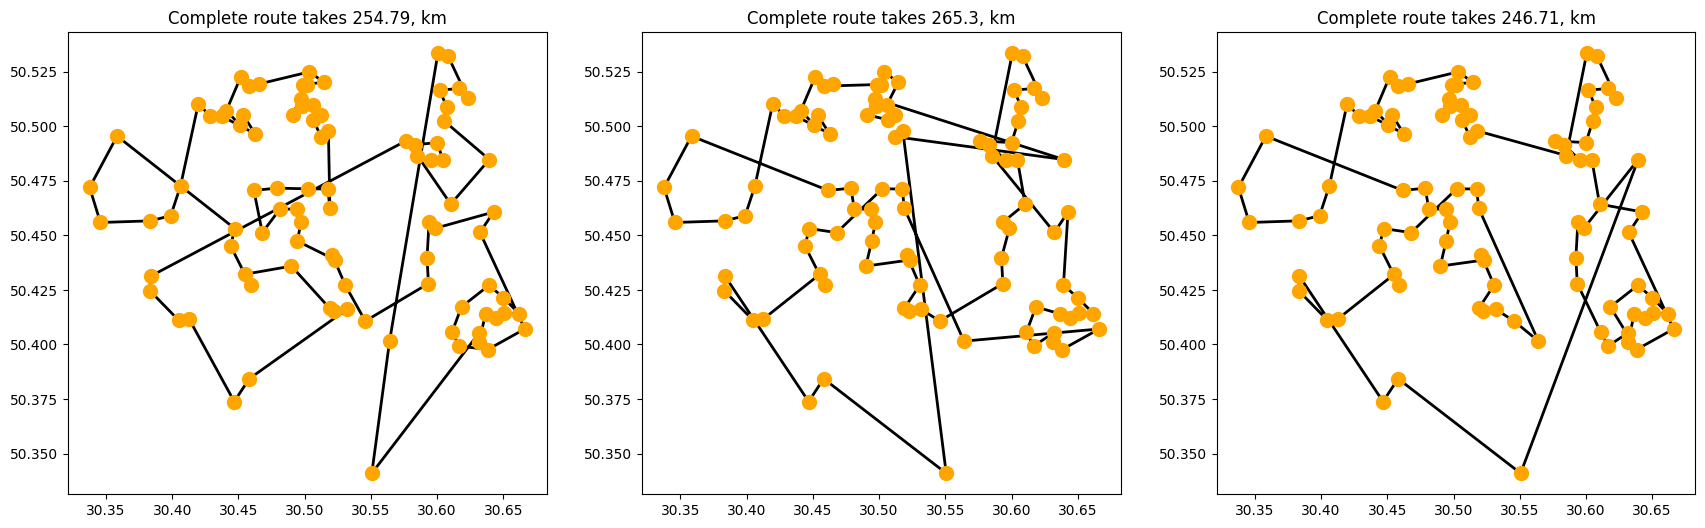

In [9]:
plt.figure(figsize=(21, 6))
plt.subplot(131)
plot_path(path1)
plt.subplot(132)
plot_path(path2)
plt.subplot(133)
plot_path(path3)
plt.show()

In [10]:
dist_min = np.inf
for i in range(len(G)):
    path = greedy_algo(G, starting_node=i)
    dist = get_route_distance_km(G, path)
    if dist < dist_min:
        dist_min = dist
print(f"The best possible route by greedy algo (nearest neighbor search) is {dist_min} km")

The best possible route by greedy algo (nearest neighbor search) is 225.36 km


### Immediately we obtain a good result, but it can be improved. There is a feasible solution that guarantees optimal result - Held Karp algorithm, it is an algorithm that based on dynamic programming principles, it works in O($2^nn^2$) time which is quite high for n=92. There is a good approximation implemented in NetworkX (networkx.algorithms.approximation.asadpour_atsp), I tried to run it, but it takes more than 24 hours. So, I turn to Local Search approach - I considered Genetic Algorithm or Simulated Annealing and chose the second one as it is implemented in a package frigidum
# Simulated Annealing

In [11]:
import frigidum
from frigidum.examples import tsp

tsp.nodes_count = 92
tsp.dist_eu = nx.attr_matrix(G, edge_attr="route_distance")[0]

if "path_sa" not in os.listdir('saved_data'):
    local_opt = frigidum.sa(random_start=tsp.random_start,
                            objective_function=tsp.objective_function,
                            neighbours=[tsp.euclidian_bomb_and_fix, tsp.euclidian_nuke_and_fix, tsp.route_bomb_and_fix, tsp.route_nuke_and_fix, tsp.random_disconnect_vertices_and_fix],
                            copy_state=frigidum.annealing.naked,
                            T_start=5,
                            alpha=.99,
                            T_stop=0.001,
                            repeats=500,
                            post_annealing = tsp.local_search_2opt)
    path_sa = local_opt[0]
    pickle.dump(path_sa, open("saved_data/path_sa", 'wb'))
else:
    path_sa = pickle.load(open("saved_data/path_sa", 'rb'))

T: 0.001, M: 0.03, O_min: 204131.7900, O_current: 204131.7900: 100%|██████████| 848/848 [16:24<00:00,  1.16s/cooling]

---
Neighbour Statistics: 
(proportion of proposals which got accepted *and* changed the objective function)
   euclidian_bomb_and_fix           : 0.097159
   euclidian_nuke_and_fix           : 0.035474
   route_bomb_and_fix               : 0.024118
   route_nuke_and_fix               : 0.000224
   random_disconnect_vertices_and_  : 0.000035
---
(Local) Minimum Objective Value Found: 
   204131.79000000


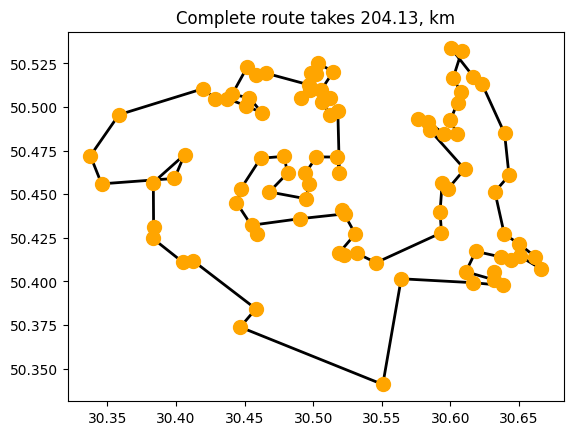

In [12]:
plot_path(path_sa)
plt.show()